 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="http://localhost:8888/notebooks/Data-Science-Bowl-2018/U-net/test-Unet-kernel-modif.ipynb#kernel-de-kaggle-(mais-avec-qlq-modifs)" data-toc-modified-id="kernel-de-kaggle-(mais-avec-qlq-modifs)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>kernel de kaggle (mais avec qlq modifs)</a></span></li><li><span><a href="http://localhost:8888/notebooks/Data-Science-Bowl-2018/U-net/test-Unet-kernel-modif.ipynb#tests-d'autres-methodes-de-segmentation" data-toc-modified-id="tests-d'autres-methodes-de-segmentation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>tests d'autres methodes de segmentation</a></span></li><li><span><a href="http://localhost:8888/notebooks/Data-Science-Bowl-2018/U-net/test-Unet-kernel-modif.ipynb#exemple-d'utilisation-de-watershed-(documentation-de-la-fonction-watershed)" data-toc-modified-id="exemple-d'utilisation-de-watershed-(documentation-de-la-fonction-watershed)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>exemple d'utilisation de watershed (documentation de la fonction watershed)</a></span></li><li><span><a href="http://localhost:8888/notebooks/Data-Science-Bowl-2018/U-net/test-Unet-kernel-modif.ipynb#Noir-et-blanc" data-toc-modified-id="Noir-et-blanc-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Noir et blanc</a></span></li></ul></div>

In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf
%matplotlib inline

# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = '../input/stage1_train/'
TEST_PATH = '../input/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

Using TensorFlow backend.


In [2]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

# kernel de kaggle (mais avec qlq modifs)

In [3]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [01:53<00:00,  5.89it/s]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:01<00:00, 62.59it/s]

Done!


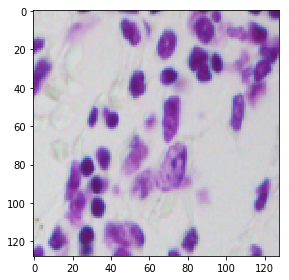

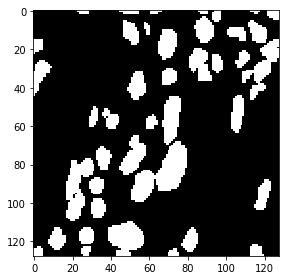

In [12]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [23]:
#Y_train[ix].shape

(128, 128, 1)

In [4]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [14]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 128, 128, 3)   0                                            
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 128, 128, 3)   0           input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 128, 128, 16)  448         lambda_1[0][0]                   
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 128, 128, 16)  0           conv2d_1[0][0]                   
___________________________________________________________________________________________

In [15]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[earlystopper, checkpointer])

Train on 603 samples, validate on 67 samples
Epoch 1/50
603/603 [==============================] - 86s - loss: 0.4425 - mean_iou: 0.4118 - val_loss: 0.2858 - val_mean_iou: 0.4313
Epoch 2/50
603/603 [==============================] - 86s - loss: 0.2422 - mean_iou: 0.4650 - val_loss: 0.1692 - val_mean_iou: 0.5018
Epoch 3/50
603/603 [==============================] - 88s - loss: 0.1578 - mean_iou: 0.5375 - val_loss: 0.1632 - val_mean_iou: 0.5719
Epoch 4/50
603/603 [==============================] - 83s - loss: 0.1282 - mean_iou: 0.5988 - val_loss: 0.1494 - val_mean_iou: 0.6230
Epoch 5/50
603/603 [==============================] - 83s - loss: 0.1159 - mean_iou: 0.6416 - val_loss: 0.1037 - val_mean_iou: 0.6575
Epoch 6/50
603/603 [==============================] - 77s - loss: 0.1065 - mean_iou: 0.6713 - val_loss: 0.1185 - val_mean_iou: 0.6833
Epoch 7/50
603/603 [==============================] - 83s - loss: 0.1037 - mean_iou: 0.6938 - val_loss: 0.0909 - val_mean_iou: 0.7032
Epoch 8/50
603/60

In [5]:
# Predict on train, val and test
model = load_model('../model/2018-02-22_yohann_Unet-kernel_0-269.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

/tensorflow/lib/python3.6/site-packages/keras/models.py:291: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


65/65 [==============================] - 2s 38ms/step


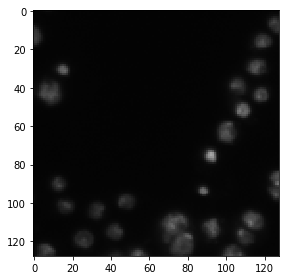

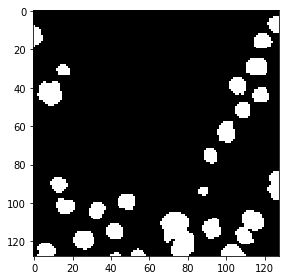

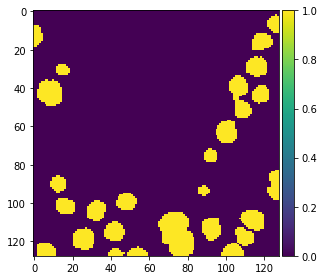

In [6]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

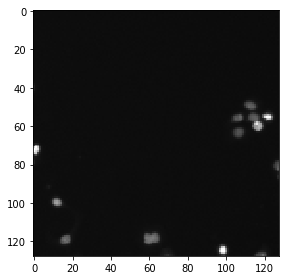

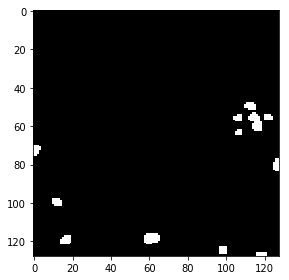

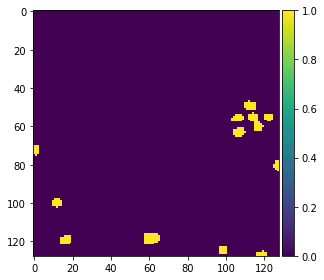

In [34]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [115]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = make_label(x > cutoff) # lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [117]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [118]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('../submission/2018-03-09_yohann_make_label_1.csv', index=False)

# tests d'autres methodes de segmentation

In [ ]:
from skimage.morphology import watershed
from skimage.morphology import remove_small_holes, remove_small_objects, dilation, convex_hull_object
from scipy import ndimage as ndi
from skimage.feature import peak_local_max


(128, 128)
(256, 256)
[[ 0.03884508  0.01616355  0.00731222 ...,  0.04756565  0.07640737
   0.17103176]
 [ 0.01535571  0.0031805   0.00176897 ...,  0.01352905  0.01811189
   0.07766674]
 [ 0.00814605  0.00140966  0.00059971 ...,  0.0038095   0.006019
   0.03498077]
 ..., 
 [ 0.01170884  0.00141401  0.00055207 ...,  0.00098672  0.00193691
   0.01038463]
 [ 0.01769462  0.00256186  0.00139145 ...,  0.00160996  0.00242789
   0.01568857]
 [ 0.06024896  0.01273225  0.00737096 ...,  0.00741881  0.00960157
   0.03855335]]
[[ 0.02185036  0.02488103  0.01637545 ...,  0.0750476   0.11053175
   0.09620536]
 [ 0.02472956  0.027959    0.01793153 ...,  0.08329775  0.12622625
   0.11076788]
 [ 0.01592104  0.0175276   0.01012671 ...,  0.04976632  0.08392744
   0.075756  ]
 ..., 
 [ 0.0212499   0.02252602  0.01091164 ...,  0.00851717  0.0171089
   0.01605357]
 [ 0.03720778  0.03975519  0.02004483 ...,  0.0140654   0.0265799
   0.02462787]
 [ 0.03389004  0.03627734  0.01845857 ...,  0.01262963  0.0234865

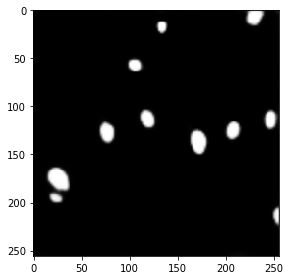

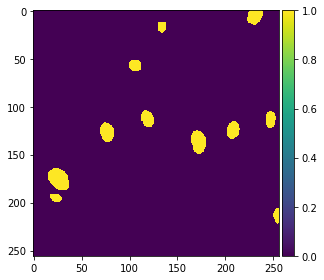

In [22]:
print(np.squeeze(preds_test[0]).shape)
print(preds_test_upsampled[0].shape)
print(np.squeeze(preds_test[0]))
print(preds_test_upsampled[0])

imshow(preds_test_upsampled[0])
plt.show()
imshow((preds_test_upsampled[0] > 0.5) * 1)
plt.show()

In [394]:
res = watershed(preds_test_upsampled[0], markers=11, mask = (preds_test_upsampled[0] > 0.5))
print(res)

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


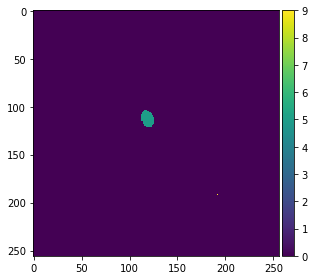

In [54]:
imshow(res)

In [55]:
np.unique(res)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

[[False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]
 ..., 
 [False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]]


18

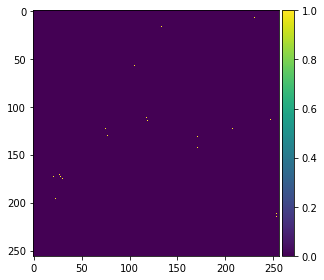

In [57]:
max_local = peak_local_max(preds_test_upsampled[0], labels=(preds_test_upsampled[0] > 0.5),
                            footprint=np.ones((3, 3)),
                            indices=False)
print(max_local)
imshow(max_local)
max_local.sum()

In [389]:
def make_label(y_pred):
    # labelling method which uses first distance_transform_edt, then find local maxima on the distances to build the
    # markers used in watershed
    
    y_pred_t = (y_pred > 0.5)
    #imshow(y_pred_t)
    #plt.show()
    distance = ndi.distance_transform_edt(y_pred_t)
    #imshow(distance)
    #plt.show()
    labels = label(y_pred_t)
    max_local_distance = peak_local_max(distance,
                                    min_distance = 10,
                                    exclude_border = 0,    
                                    #footprint=np.ones((10, 10)),
                                    labels =labels, # y_pred_t
                                    indices=False)
    #imshow(max_local_distance)
    #plt.show()
    #print(max_local_distance.sum())
    markers = ndi.label(max_local_distance)[0]
    #print(distance.shape)
    #print(y_pred_t.shape)
    #print(markers.shape)
    res = watershed(-distance, markers=markers, mask = y_pred_t) #, compactness=0.1
    #imshow(res)
    #plt.show()
    return res


In [374]:
def make_label(y_pred):
    # labelling method with direct uses of watershed, using markers = some_integer
    
    y_pred_t = (y_pred > 0.5)
    #imshow(y_pred_t)
    #plt.show()
    #distance = ndi.distance_transform_edt(y_pred_t)
    #imshow(distance)
    #plt.show()
    #labels = label(y_pred_t)
    #max_local_distance = peak_local_max(distance,
    #                                #min_distance = 10,
    #                                exclude_border = 0,
    #                                footprint=np.ones((10, 10)),
    #                                labels =labels, # y_pred_t
    #                                indices=False)
    #imshow(max_local_distance)
    #plt.show()
    #print(max_local_distance.sum())
    #markers = ndi.label(max_local_distance)[0]
    #print(distance.shape)
    #print(y_pred_t.shape)
    #print(markers.shape)
    y_pred2 = dilation(image=y_pred)
    res = watershed(-y_pred, markers=1000, mask = y_pred_t) #, compactness=0.1
    res = remove_small_objects(res, min_size=16)
    #res = convex_hull_object(res)
    #res = remove_small_holes(res, min_size=9)
    #res = binary_dilation(image=res)
    #res = watershed(res, markers=1000, mask = y_pred_t)
    #imshow(res)
    #plt.show()
    return res

In [390]:
def shuffle_label(x):
    # it is usefull to shuffle the labels so that one can distinct the cells when plotting them
    y = np.zeros_like(x)
    new_labels = np.random.permutation(np.unique(x)[1:])
    for index, i in enumerate(np.unique(x)[1:]): #range(1, np.max(x) + 1):
        y[x == i]  = new_labels[index]
    return y

44afae184c89e6ba55985b4d341acc1ae1e8b6ef96312064e0e6e630e022b078


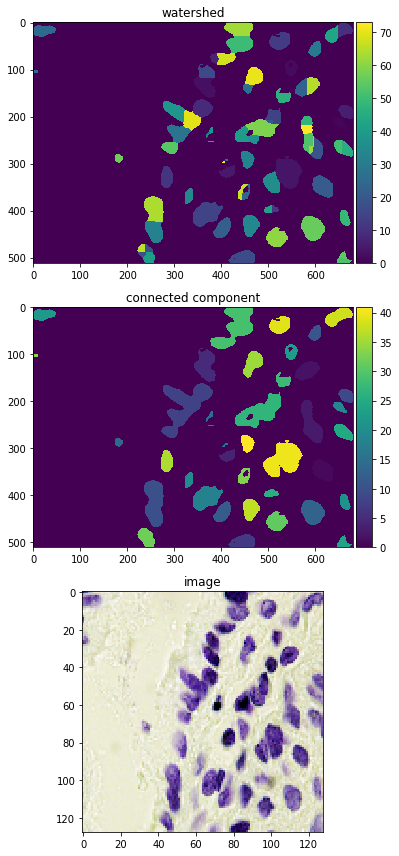

In [393]:

j = 1
print(test_ids[j])


fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1,  figsize=(12, 12))
res = shuffle_label(make_label(y_pred=preds_test_upsampled[j]))
imshow(res, ax = ax0)
ax0.set(title='watershed')
#plt.show()
#ax2 = fig.add_subplot(312)
#plt.subplot(3, 1, 2)
imshow(shuffle_label(label(preds_test_upsampled[j] > 0.5)), ax = ax1)
ax1.set(title='connected component')
#plt.show()
#ax3 = fig.add_subplot(313)
#plt.subplot(3, 1, 3)
imshow(np.squeeze(X_test[j]), ax = ax2)
ax2.set(title='image')
#plt.show()

#print(res)
#print(np.unique(res))
#print(np.unique(label(preds_test_upsampled[j] > 0.5)))

In [384]:
len(np.unique(res))

59

# exemple d'utilisation de watershed (documentation de la fonction watershed)

[[ 0  0  0 ...,  0  0  0]
 [ 1  1  1 ...,  1  1  1]
 [ 2  2  2 ...,  2  2  2]
 ..., 
 [77 77 77 ..., 77 77 77]
 [78 78 78 ..., 78 78 78]
 [79 79 79 ..., 79 79 79]]
[[ 0  1  2 ..., 77 78 79]
 [ 0  1  2 ..., 77 78 79]
 [ 0  1  2 ..., 77 78 79]
 ..., 
 [ 0  1  2 ..., 77 78 79]
 [ 0  1  2 ..., 77 78 79]
 [ 0  1  2 ..., 77 78 79]]


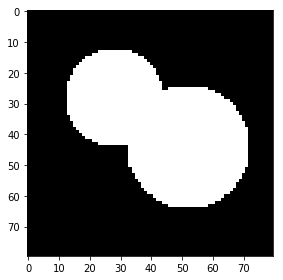

In [43]:
x, y = np.indices((80, 80))
x1, y1, x2, y2 = 28, 28, 44, 52
r1, r2 = 16, 20
mask_circle1 = (x - x1)**2 + (y - y1)**2 < r1**2
mask_circle2 = (x - x2)**2 + (y - y2)**2 < r2**2
image = np.logical_or(mask_circle1, mask_circle2)

print(x)
print(y)
imshow(image)

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


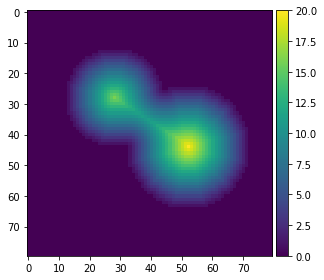

In [45]:
distance = ndi.distance_transform_edt(image)
print(distance)
imshow(distance)

[[False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]
 ..., 
 [False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]]


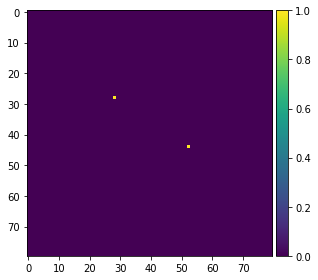

In [49]:
local_maxi = peak_local_max(distance, labels=image,
                            footprint=np.ones((3, 3)),
                            indices=False)
print(local_maxi)
imshow(local_maxi)

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


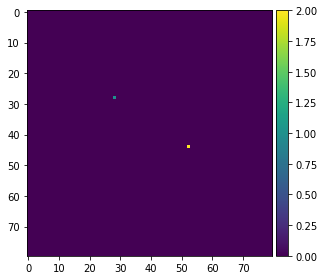

In [50]:
markers = ndi.label(local_maxi)[0]
print(markers)
imshow(markers)

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


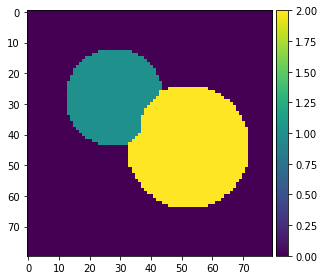

In [51]:
labels = watershed(-distance, markers, mask=image)
print(labels)
imshow(labels)

# Noir et blanc

In [29]:
from skimage.color import rgb2gray

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1


In [30]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32) #np.uint8
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:3]
    img = rgb2gray(img)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)#np.uint8
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:3]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = rgb2gray(img)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [02:42<00:00,  4.12it/s]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:01<00:00, 32.93it/s]

Done!


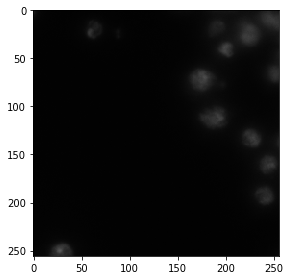

In [20]:
imshow(np.squeeze(X_train[0]))

In [21]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [40]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
#s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 256, 256, 16) 160         input_4[0][0]                    
__________________________________________________________________________________________________
dropout_28 (Dropout)            (None, 256, 256, 16) 0           conv2d_58[0][0]                  
__________________________________________________________________________________________________
conv2d_59 (Conv2D)              (None, 256, 256, 16) 2320        dropout_28[0][0]                 
__________________________________________________________________________________________________
max_poolin

In [41]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-bw1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[earlystopper, checkpointer])

Train on 603 samples, validate on 67 samples
Epoch 1/50
603/603 [==============================] - 294s 488ms/step - loss: 0.4822 - mean_iou: 0.4159 - val_loss: 0.3237 - val_mean_iou: 0.4242

Epoch 00001: val_loss improved from inf to 0.32365, saving model to model-dsbowl2018-bw1.h5
Epoch 2/50
603/603 [==============================] - 285s 473ms/step - loss: 0.2941 - mean_iou: 0.4339 - val_loss: 0.1938 - val_mean_iou: 0.4568

Epoch 00002: val_loss improved from 0.32365 to 0.19381, saving model to model-dsbowl2018-bw1.h5
Epoch 3/50
603/603 [==============================] - 297s 493ms/step - loss: 0.1937 - mean_iou: 0.4905 - val_loss: 0.1765 - val_mean_iou: 0.5233

Epoch 00003: val_loss improved from 0.19381 to 0.17647, saving model to model-dsbowl2018-bw1.h5
Epoch 4/50
603/603 [==============================] - 287s 477ms/step - loss: 0.1546 - mean_iou: 0.5498 - val_loss: 0.1311 - val_mean_iou: 0.5732

Epoch 00004: val_loss improved from 0.17647 to 0.13108, saving model to model-dsbow

In [44]:
# Predict on train, val and test
model = load_model('model-dsbowl2018-bw1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

65/65 [==============================] - 10s 149ms/step


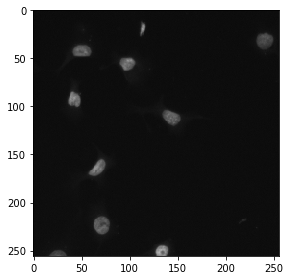

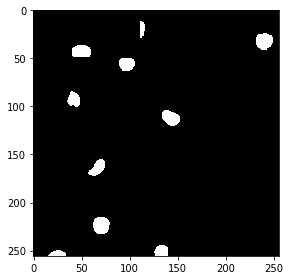

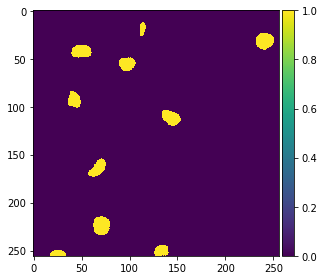

In [46]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(np.squeeze(X_train[ix]))
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

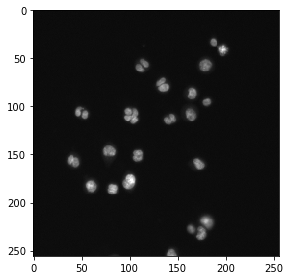

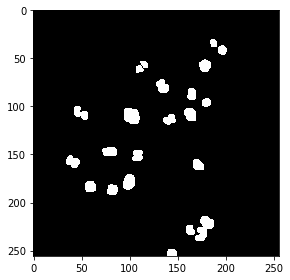

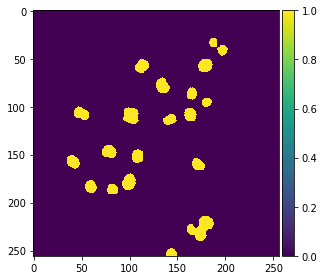

In [47]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(np.squeeze(X_train[int(X_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [48]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

In [49]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [50]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [51]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('../submission/sub-dsbowl2018-bw1.csv', index=False)